### What is this post about?

I'm currently listening to the _Life and Work Principles_ by Ray Dalio - the famous Bridgewater hedge fund manager & founder. In it he briefly touches upon the successes of his investment strategies, out of which one was focused on investing into uncorrelated stocks. This got me thinking about the generally high correlation in the cryptocurrency market so I decided to see if there are any tokens that behave differently from the rest. Hence, here we are and below I quickly recap the code, the findings and the takeaways from this quick exercise.

### Tools and Game Plan

To get the historical cryptocurrency data I make use of the freely accesible [CoinGecko API](https://www.coingecko.com/en/api) and its [Python3 wrapper](https://github.com/man-c/pycoingecko). The game plan is to look at cryptocurrencies that have been traded for at least 3 years, and construct a portfolio consisting of uncorrelated tokens. Apart from the CoinGecko API, I use the pandas, numpy, matplotlib, seaborn and the datetime packages. The code is quite heavily commented so hopefully the interested reader can comprehend all the steps just by reading through it.

In [369]:
# Imports
#--------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt

#---------------
# CoingGecko API
#---------------
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [421]:
# Current data for top 500 coins by Market Cap - 100 coins per page
#------------------------------------------------------------------
coins = pd.DataFrame(cg.get_coins_markets(vs_currency = 'usd'))
for page in range(2,6):
    coins = pd.concat([coins, pd.DataFrame(cg.get_coins_markets(vs_currency = 'usd', page = page))])

coins = coins.reset_index(drop = True)
coins

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,37978.000000,723476227588,1,7.984846e+11,2.291839e+10,38747.000000,...,2.100000e+07,2.100000e+07,69045.000000,-44.91950,2021-11-10T14:24:11.849Z,67.810000,55984.30690,2013-07-06T00:00:00.000Z,None,2022-05-01T07:56:55.013Z
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2773.960000,334692571096,2,NaN,1.430243e+10,2838.580000,...,NaN,NaN,4878.260000,-43.05475,2021-11-10T14:24:19.604Z,0.432979,641487.36811,2015-10-20T00:00:00.000Z,"{'times': 96.5436231164556, 'currency': 'btc',...",2022-05-01T07:55:34.686Z
2,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.000000,83223328899,3,NaN,5.450827e+10,1.008000,...,8.315288e+10,NaN,1.320000,-24.33295,2018-07-24T00:00:00.000Z,0.572521,74.86646,2015-03-02T00:00:00.000Z,None,2022-05-01T07:56:39.281Z
3,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,383.420000,64449760501,4,6.444976e+10,1.641067e+09,399.140000,...,1.681370e+08,1.681370e+08,686.310000,-44.11107,2021-05-10T07:24:17.097Z,0.039818,963213.88135,2017-10-19T00:00:00.000Z,None,2022-05-01T07:55:51.903Z
4,usd-coin,usdc,USD Coin,https://assets.coingecko.com/coins/images/6319...,0.997881,49148736774,5,NaN,4.843504e+09,1.008000,...,4.925730e+10,NaN,1.170000,-14.83687,2019-05-08T00:40:28.300Z,0.891848,11.98245,2021-05-19T13:14:05.611Z,None,2022-05-01T07:56:16.585Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,loom-network,loomold,Loom Network (OLD),https://assets.coingecko.com/coins/images/3387...,0.072888,60862366,496,NaN,8.319810e+05,0.077840,...,1.000000e+09,NaN,0.772485,-90.53623,2018-05-04T02:54:44.763Z,0.007863,829.69306,2020-03-13T02:29:21.252Z,"{'times': -0.040944318462860264, 'currency': '...",2022-05-01T07:56:41.065Z
496,alpaca-finance,alpaca,Alpaca Finance,https://assets.coingecko.com/coins/images/1416...,0.392706,60584229,497,7.374088e+07,1.571413e+07,0.498935,...,1.731944e+08,1.880000e+08,8.780000,-95.53945,2021-03-06T00:42:02.012Z,0.255041,53.47390,2022-01-22T10:22:25.064Z,None,2022-05-01T07:55:58.118Z
497,bonfida,fida,Bonfida,https://assets.coingecko.com/coins/images/1339...,1.055000,60300996,498,1.055902e+09,7.316072e+06,1.240000,...,1.000000e+09,1.000000e+09,18.770000,-94.38151,2021-11-03T20:34:33.492Z,0.113165,832.10970,2020-12-22T10:58:52.143Z,None,2022-05-01T07:56:23.352Z
498,verus-coin,vrsc,Verus Coin,https://assets.coingecko.com/coins/images/6769...,0.878641,59825639,499,NaN,3.679900e+04,0.925022,...,8.354018e+07,NaN,3.520000,-75.00902,2021-05-01T23:29:00.762Z,0.001778,49311.58460,2020-11-29T04:57:39.065Z,None,2022-05-01T07:51:15.973Z


In [330]:
# Keeping only coins with 3+ year history on the market
#------------------------------------------------------
from datetime import datetime, timezone
#--------------------------------------
jan19 = datetime.strptime('2019-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')    # 1st Jan 2019
jan19 = dt.replace(tzinfo=timezone.utc).isoformat()                      # formatting like in the API

coins["atl_date"] = pd.to_datetime(coins["atl_date"])                    # changing type to datetime
coins = coins.loc[coins["atl_date"] < jan19]                             # keeping only coins older than 3 years
coins = coins.reset_index(drop = True)
coins

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,38357.000000,730178553834,1,8.059056e+11,2.004939e+10,38801.000000,...,2.100000e+07,2.100000e+07,69045.000000,-44.45523,2021-11-10T14:24:11.849Z,67.810000,56457.03434,2013-07-06 00:00:00+00:00,None,2022-04-30T18:13:40.062Z
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2793.330000,336986058000,2,NaN,1.253951e+10,2841.350000,...,NaN,NaN,4878.260000,-42.75991,2021-11-10T14:24:19.604Z,0.432979,644809.25105,2015-10-20 00:00:00+00:00,"{'times': 96.33730439594328, 'currency': 'btc'...",2022-04-30T18:12:48.747Z
2,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.001000,83254158899,3,NaN,4.428167e+10,1.002000,...,8.315288e+10,NaN,1.320000,-24.30444,2018-07-24T00:00:00.000Z,0.572521,74.93234,2015-03-02 00:00:00+00:00,None,2022-04-30T18:12:11.563Z
3,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,390.840000,65826723112,4,6.582672e+10,1.150386e+09,399.800000,...,1.681370e+08,1.681370e+08,686.310000,-43.06657,2021-05-10T07:24:17.097Z,0.039818,981217.09381,2017-10-19 00:00:00+00:00,None,2022-04-30T18:14:11.273Z
4,ripple,xrp,XRP,https://assets.coingecko.com/coins/images/44/l...,0.610433,29353852829,7,6.102008e+10,2.304907e+09,0.628349,...,1.000000e+11,1.000000e+11,3.400000,-82.13775,2018-01-07T00:00:00.000Z,0.002686,22498.40152,2014-05-22 00:00:00+00:00,None,2022-04-30T18:13:46.614Z
5,dogecoin,doge,Dogecoin,https://assets.coingecko.com/coins/images/5/la...,0.131988,17501590218,12,NaN,8.279380e+08,0.137505,...,NaN,NaN,0.731578,-81.97014,2021-05-08T05:08:23.458Z,0.000087,151679.95328,2015-05-06 00:00:00+00:00,None,2022-04-30T18:13:24.449Z
6,litecoin,ltc,Litecoin,https://assets.coingecko.com/coins/images/2/la...,99.170000,6971161593,22,8.343390e+09,5.248294e+08,101.510000,...,8.400000e+07,8.400000e+07,410.260000,-75.78326,2021-05-10T03:13:07.904Z,1.150000,8547.97098,2015-01-14 00:00:00+00:00,None,2022-04-30T18:14:31.331Z
7,tron,trx,TRON,https://assets.coingecko.com/coins/images/1094...,0.062217,6330282978,24,NaN,9.595356e+08,0.065293,...,1.019004e+11,NaN,0.231673,-73.11917,2018-01-05T00:00:00.000Z,0.001804,3351.42885,2017-11-12 00:00:00+00:00,"{'times': 31.74566190771241, 'currency': 'usd'...",2022-04-30T18:14:41.707Z
8,bitcoin-cash,bch,Bitcoin Cash,https://assets.coingecko.com/coins/images/780/...,286.750000,5464172203,26,6.023244e+09,2.830750e+08,297.860000,...,2.100000e+07,2.100000e+07,3785.820000,-92.41509,2017-12-20T00:00:00.000Z,76.930000,273.23952,2018-12-16 00:00:00+00:00,None,2022-04-30T18:13:20.402Z
9,chainlink,link,Chainlink,https://assets.coingecko.com/coins/images/877/...,11.600000,5421516503,27,1.160901e+10,3.911993e+08,12.240000,...,1.000000e+09,1.000000e+09,52.700000,-78.02884,2021-05-10T00:13:57.214Z,0.148183,7713.33974,2017-11-29 00:00:00+00:00,None,2022-04-30T18:13:47.214Z


In the next step I first create the `price_history` dataframe using the historical prices of bitcoin after which I itterativelly populate it with new columns corresponding to all the other coins. I use the time index returned by the API to match the correct rows and set all other rows to `NaN`.

In [331]:
# Historical Price Data for up to 2000 days before 30/04/2022
#------------------------------------------------------------
coin_ids = coins['id']
bitcoin = cg.get_coin_market_chart_by_id(id = 'bitcoin', days = '2000', vs_currency = 'usd')["prices"]
price_history = pd.DataFrame(bitcoin, columns = ["index", "bitcoin"])

for coin_id in coin_ids[1:]:
    coin = cg.get_coin_market_chart_by_id(id = coin_id, days = '2000', vs_currency = 'usd')["prices"]
    coin = pd.DataFrame(coin, columns = ["index", coin_id])
    price_history = price_history.join(coin.set_index("index"), on = "index")
    
price_history

,index,bitcoin,ethereum,tether,binancecoin,ripple,dogecoin,litecoin,tron,bitcoin-cash,...,steem,numeraire,verge,ark,asd,aragon,stratis,maidsafecoin,iexec-rlc,augur
0,1478563200000,708.940000,10.890106,1.000000,NaN,0.008239,0.000228,3.838584,NaN,NaN,...,0.133704,NaN,0.000021,NaN,NaN,NaN,0.069805,0.079964,NaN,4.790000
1,1478649600000,721.177500,10.664918,1.000000,NaN,0.008087,0.000229,3.849884,NaN,NaN,...,0.148576,NaN,0.000022,NaN,NaN,NaN,0.064342,0.077728,NaN,4.450000
2,1478736000000,713.214143,10.519281,0.999997,NaN,0.008137,0.000230,3.812256,NaN,NaN,...,0.153180,NaN,0.000021,NaN,NaN,NaN,0.069549,0.076865,NaN,4.900000
3,1478822400000,715.642500,10.293087,1.000000,NaN,0.008062,0.000226,3.817239,NaN,NaN,...,0.127085,NaN,0.000021,NaN,NaN,NaN,0.087305,0.076074,NaN,4.840000
4,1478908800000,703.760000,9.664325,1.000000,NaN,0.008047,0.000223,3.754012,NaN,NaN,...,0.122182,NaN,0.000021,NaN,NaN,NaN,0.086133,0.076165,NaN,4.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1651017600000,38134.215451,2806.748836,1.000501,385.027613,0.642326,0.138032,98.472060,0.061942,296.100585,...,0.439145,25.476484,0.009321,0.922246,0.198598,3.725051,0.984225,0.276582,1.736587,12.812804
1997,1651104000000,39237.949317,2889.592223,0.999849,391.285543,0.652835,0.140246,100.514884,0.063180,307.473039,...,0.546993,25.110015,0.009547,0.943347,0.198518,3.859121,1.013390,0.283103,1.784559,13.165825
1998,1651190400000,39741.766646,2932.455084,0.999654,406.326688,0.644127,0.137214,103.105912,0.063653,306.538849,...,0.477371,25.115812,0.009321,0.948837,0.191595,3.848096,1.004725,0.289798,1.780006,13.394428
1999,1651276800000,38650.550138,2817.489882,1.001222,392.964375,0.612456,0.135080,100.369428,0.063630,294.633053,...,0.478391,23.651649,0.008742,0.906787,0.185225,3.609127,0.975365,0.278096,1.644444,12.885204


In [341]:
# Removing stable coins
#----------------------
stable_coins = (price_history.mean() < 1.02) & (price_history.mean() > 0.98)
price_history = price_history.loc[:, ~stable_coins.values]

Finally we get to see what we were after. Below the correlation matrix reveals that there indeed are some tokens that seem to behave quite differently from the rest. The white(-er) squares correspond to pairs of cryptocurrencies that are highly uncorrelated, thus useful for diversification of one's crypto portfolio. To further find the actual pairs, in the next code chunk I re-format the correlation matrix into a so-called long format and only look at the pairs of coins that have correlation of less than 0.05 in absolute value.

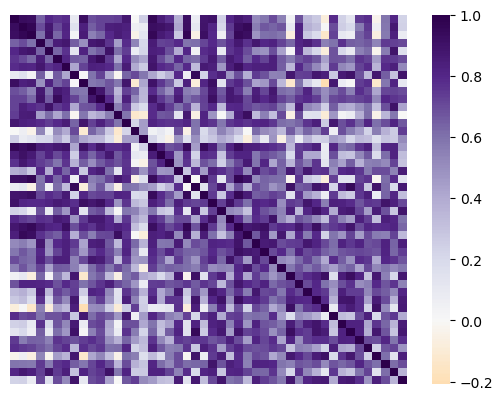

In [433]:
# Correlation matrix
#-------------------
corr = price_history.iloc[1:, 1:].corr()       # ignore the API's time index column (and row)
sb.heatmap(corr, cmap = 'PuOr', center = 0, annot = False, yticklabels = False, xticklabels = False)
plt.show()

In [446]:
# Create a long format correlation table
#---------------------------------------
corr_long = corr.reset_index().melt(id_vars="index")                                     # transform to long format
corr_long = corr_long.loc[(corr_long["value"] != 1.0).values].reset_index(drop = True)   # drop self-correlations
corr_long["abs_val"] = np.abs(corr_long["value"])                                        # create absolute value column
corr_long = corr_long.sort_values("abs_val")                                             # sort by absolute value
corr_long = corr_long.iloc[::2]                                                          # drop duplicates
corr_long.loc[corr_long["abs_val"] < 0.05]                                               # display uncorrelated tokens

,index,variable,value,abs_val
2037,decentraland,augur,0.001086,0.001086
920,dash,enjincoin,0.001412,0.001412
1092,decentraland,nem,0.002478,0.002478
630,bitcoin,eos,0.002628,0.002628
1229,eos,rocket-pool,0.003400,0.003400
367,bitcoin-cash,chainlink,0.004519,0.004519
80,steem,ethereum,0.012647,0.012647
398,ark,chainlink,0.014588,0.014588
1910,enjincoin,stratis,-0.015294,0.015294
547,bitcoin-cash,decentraland,-0.015555,0.015555


As we can see, there are quite a few pairs of tokens that exhibit correlation of up to 5%. And there are even 6 pairs that have a correlation value of less than 1%. One such pair is Bitcoin and EOS, whose correlation is only $\approx 0.002$. This seems to make EOS a very good candidate to pair with bitcoin in order to achieve a higher degree of diversification. This is just one such pair that I mention though, and by no means I am giving here any sort of investment advice. In fact, I know about investing probably as much as I know about making ketchup. That is, I know what are the ingredients but I am lacking the experience in carrying out the recipe and there is a very high chance my ketchup wouldn't taste very good. So feel free to play around with this code, explore the correlations on your own, and if you come up with some sensible strategy for your crypto investments thanks to it, then I am happy I could help :)

Finally, below I make a quick time series plot of Bitcoin, EOS and Nexo to see for myself the correlatedness/uncorrelatedness of those tokens.

In [410]:
# Create dates for the x-axis
#----------------------------
from datetime import datetime, timedelta
#---------------------------------------

def datetime_range(start = None, end = None, interval = 1):
    span = end - start
    for i in range(0, span.days + 1, interval):
        yield start + timedelta(days = i)
        
today = dt.datetime.today()
start = today - dt.timedelta(days = 2000)
xaxis = list(datetime_range(start, today, 200))
xaxis = [date.strftime("%d/%m/%Y") for date in xaxis]

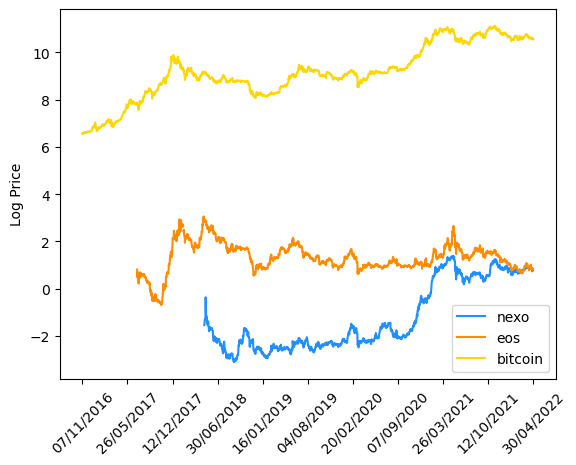

In [441]:
# Plot the price evolution of 
#----------------------------
np.log(price_history["nexo"]).plot(color = "dodgerblue")
np.log(price_history["eos"]).plot(color = "darkorange")
np.log(price_history["bitcoin"]).plot(color = "gold")

import matplotlib.dates as mdates
plt.ylabel("Log Price")
plt.legend(["nexo", "eos", "bitcoin"])
plt.xticks(range(0, 2001, 200), xaxis, rotation = 45)
plt.show()

### Final thoughts 

As with every "little" coding exercise, this one also took longer than expected. But I have learned how to use the CoinGecko API and got the read a bit about the importance of diversifying one's investment portfolio with uncorrelated investments. Moreover, I learned about new crypto tokens I wasn't aware of and found out that not the whole crypto market moves un unison - which I suppose is a nice finding.